# Recurrent Neural Networks

<p>Recurrent Neural Networks (RNN) are popular models that are used frequently, for example, in Natural Language Processing (NLP). Usually, in neural networks we assume that all inputs (and outputs) are independent of each other. In RNNs, the output is dependent on the previous computations. An interesting way to think of RNNs is that it has "memory" that captures information about what has been calculated so far. In this exercise, you will implement a simple Recurrent Neural Network similar to the image below and train it on the MNIST dataset to perform classification on the MNIST digits. <p>

<img src="https://i.imgur.com/D43uEDO.png" alt="RNN Architecture" title="Figure 1" width="600" />

<p>In the image above, note the following things:</p>
<ul>
<li>$x_t$ are the pixels at time step $t$.</li>
<li>At each time step, we will feed in one row of the MNIST digit.</li>
<li>There are totally 28 time steps.</li>
<li>The hidden states are 100-dimensional. $h_t$ is the set hidden state at time step $t$.</li>
<li>$\mathcal{U}$, $\mathcal{V}$ and $\mathcal{W}$ are the weights that will be learnt and are shared across all the time steps. This is unlike standard MLP neural networks that use separate parameters at each layer.</li>
<li>We compute the output by averaging over all the hidden states.</li>
</ul>

<p>We will begin by first importing the necessary python libraries:</p>

In [64]:
import theano
import theano.tensor as T
import numpy as np
import matplotlib.pyplot as plt
import random
import six.moves.cPickle as pickle
import gzip
%matplotlib inline

print('***** Import complete *****')

***** Import complete *****


<p>Let's load the dataset. We will be using the same MNIST Handwritten digit dataset as before.</p>

In [65]:
# Open the file and load the training, validation and
# test sets.
with gzip.open('./mnist.pkl.gz', 'rb') as f:
    try:
        train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
    except:
        train_set, valid_set, test_set = pickle.load(f)

<p>The MNIST image features are of dimensions (number_of_samples x 784). Let's reshape it into (number_of_samples x 28 x 28) and obtain the feature inputs and labels.</p>

In [66]:
train_set = (train_set[0].reshape(-1, 28, 28), train_set[1])
valid_set = (valid_set[0].reshape(-1, 28, 28), valid_set[1])
test_set = (test_set[0].reshape(-1, 28, 28), test_set[1])

# Obtain the training, test and validation input features with labels
# X_train - (50000 x 28 x 28)
# Y_train - (50000 x 1)
(X_train, Y_train) = train_set

# X_valid - (10000 x 28 x 28)
# Y_valid - (10000 x 1)
(X_valid, Y_valid) = valid_set

# X_test - (10000 x 28 x 28)
# Y_test - (10000 x 1)
(X_test, Y_test) = test_set

<p>It is good practice to always shuffle your training set. Below, we do this by shuffling the indices of the training set.</p>

In [67]:
permutation = list(np.random.permutation(X_train.shape[0]))
X_train = X_train[permutation]
Y_train = Y_train[permutation]

<p>The model that we will implement, requires the class labels to be "one-hot" encoded. One-hot encoding is encoding of categorical variables in a 1 of K scheme (K being the number of classes). For example, if the digit label is 2, it would be encoded as [0, 0, 1, 0, 0, 0, 0, 0, 0, 0].</p>

In [68]:
# Creating copies of the original labels
Y_labels = Y_train
Yv_labels = Y_valid
Yt_labels = Y_test

def onehot(input):
    # Function that performs one-hot encoding
    
    # Inputs:
    # input - array of class labels
    
    # Outputs:
    # onehot - array of encoded labels
    
    ################# Insert Your Code Here ###################
    
    # Implement one-hot encoding on the class labels. Store 
    # this is in a multi-dimensional array.    
    # Hint: input is of dimensions num_samples x 1. The output, 'onehot'
    # is of dimension num_samples x 10. If the digit label is [3]
    # the equivalent one-hot encoding is [0, 0, 0, 1, 0, 0, 0, 0, 0, 0]
    onehot=np.zeros((input.size,10))
    index=np.arange(input.size)
    onehot[index,input]=1
    ##########################################################
    
    return onehot

# Perform One Hot encoding on the training, test
# and validation labels
Y_train = onehot(Y_train)
Y_valid = onehot(Y_valid)
Y_test  = onehot(Y_test) 

<p>Each step of our RNN will have 100-dimensional hidden state (refer to the figure above). These hidden states will act as the network's "memory". At each step, the current value of the hidden state is calculated based on its value in the previous step. Each sample comprises of features of dimension 28 x 28. Therefore, the number of inputs as well as time steps would be 28. Below, we initialise some of the hyper-parameters.</p>

In [69]:
# Set number of iterations
iterations = 1000

# Set number of input pixels or in other
# words, the number of horizontal pixels.
input_d = 28

# Set number of hidden units.
hidden_d = 100

# Set number of outputs.
output_d = 10

# Set mini-batch size.
mini_batch_size = 100

# Set the number of time steps or in other words the
# number of vertical input pixels.
time_steps = 28

# Set the learning rate
learning_rate = 0.1

# Set the seed for consistency
np.random.seed(1234)

<p>We now initialise all the parameters that will be learnt/optimised. Remember that in RNNs these parameters are shared among all the steps.</p>

In [70]:
# Initialise the shared weights
# Set the random state
rng = np.random.RandomState(1234)

################# Insert Your Code Here ###################

# Initialise the weights U, V and W. Use the Glorot and Bengio (2010), 
# normalized initialisation. 

# Hint: The dimensions of U will be (input_d x hidden_d), 
# W will be (hidden_d x hidden_d) and V will be (hidden_d x output_d).
# For the Glorot and Bengio initialisation refer to chapter 8, page 299,
# equation 8.23 in the Deep Learning textbook
# (online version, 21st Nov 2017).

u = np.sqrt(6/(input_d + hidden_d))
U = theano.shared(np.asanyarray(rng.uniform(-u,u,size=(input_d,hidden_d))),borrow=True)

w = np.sqrt(6/(hidden_d + hidden_d))
W = theano.shared(np.asanyarray(rng.uniform(-w,w,size=(hidden_d,hidden_d))),borrow=True)

v = np.sqrt(6/(hidden_d + output_d))
V = theano.shared(np.asanyarray(rng.uniform(-v,v,size=(hidden_d,output_d))),borrow=True)

##########################################################

# Initialise the hidden unit bias
b_hidden = theano.shared(np.zeros((hidden_d,)))

# Initialise the final output bias
b_V = theano.shared(np.zeros((output_d,)))

<p>Create the Theano data structures for the features and class labels.</p>

In [71]:
# Create 3D tensor for features
x = T.tensor3('x')

# Create matrix of one-hot encoded class labels
y = T.matrix('y')

<p>In this architecture, we use the average of all hidden states instead of using only the hidden state from the last step for performing the prediction. We create a tensor to store the hidden states ($\mathbf{h_t}$) at each time step. We are using mini-batches and have 100 hidden units. For this purpose, we need to create a tensor to accumulate the hidden state values from each time step.</p>

In [72]:
# Create a tensor for the hidden states of 
# dimensions: (mini_batch_size x 100)
h_states = T.zeros((x.shape[0], hidden_d))

# Create a tensor to accumulate the  hidden 
# states of dimensions: (mini_batch_size x 100)
h_states_sum = T.zeros((x.shape[0], hidden_d))

<p>At each time step $t$, we must compute the value of the hidden states, $\mathbf{h_t}$. We compute $\mathbf{h_t}$ based on the previous hidden state, $\mathbf{h_{t-1}}$ and the input at the current step, $\mathbf{x_t}$ using the formula: $\mathbf{h_t} = tanh((\mathcal{U}\mathbf{x_t} + \mathcal{W}\mathbf{h_{t-1}})+biases)$. This is the general form of the formula. Do not forget to keep track of the dimensions of the tensors in your implementation. We accumulate the value of the hidden states at each time step so that we can compute the mean value of the hidden states later.</p>

In [73]:
for t in range(time_steps):
    
    ################# Insert Your Code Here ###################

    # Obtain the current value of the hidden state by completing the
    # code below. 
    # For this, compute the dot products on one row of features of each
    # sample in the mini-batch and apply the non-linearity Tanh.
    
    # Hint: Observe the formula for the current value of the hidden
    # state carefully. Remember that we already have a 3 dimension
    # tensor for x which contains the training features for a 
    # mini-batch. You could access the row associated with a 
    # time-step across all samples of the mini-batch using x[:, t, :].
    # We already have U, V, W, b_hidden and h_states (which has the 
    # hidden state from the previous time step).
    
    a = T.dot(x[:,t,:],U) + T.dot(h_states,W) + b_hidden
    
    # Apply a non-linearity
    h_states = T.tanh(a)
    
    # Accumulate the hidden state values
    # Hint: Save the sum of the hidden states up to the current
    # time step.
    h_states_sum = h_states_sum + h_states 
   
    ##########################################################

<p>Now, we shall compute the final class predictions on each of the samples in the mini-batch. To do this, we average over all the values of the hidden states in each time step (However, we could have also used just the value of the final hidden state. This may not perform as well as using the mean). The final predictions can be written as: $y_{prob} = softmax((\mathcal{V} \cdot \frac{1}{\textit{timesteps}}\Sigma_{t=1}^{\textit{timesteps}}\mathbf{h_t}) + biases))$</p>

In [74]:
################# Insert Your Code Here ###################

# Observe the above formula for finding the final prediction 
# probabilities for each class and complete the code below.

# Compute the mean of the hidden states
# Hint: We already calculated the sum of the hidden states
# above.
h_states_mean = h_states_sum/time_steps

# Compute the dot product and add the bias
# Hint: We calculated h_states_mean above. Now, observe
# the formula again. Compute the dot product with the
# corresponding weight. Do not forget to add the bias b_V!
y_hat = T.dot(h_states_mean,V) + b_V

# Apply the softmax function to get 10 outputs per sample
# with values ranging from 0 to 1.
# Hint: All we have left is to pass the above computation 
# into the softmax function.
y_prob = T.nnet.softmax(y_hat)

##########################################################

# Choose the class with the highest probability
y_pred = T.argmax(y_prob, axis = 1)

<p>Stochastic Gradient Descent will be used to train the parameters. We must define a cost function that is optimised. The Categorical Cross-Entropy will be used as the cost.</p>

In [75]:
################# Insert Your Code Here ###################

# Compute the cost across all samples in the mini-batch. 
# Here we shall use the categorical cross-entropy.

# Hint: Use T.nnet.categorical_crossentropy. Check the 
# Theano documentation for more information. Refer to the 
# previous demonstrations to see how the cost is computed.
cost = T.nnet.categorical_crossentropy(y_prob,y).mean()

##########################################################

<p>Compute the gradients for each of the parameters as before:</p>

In [76]:
grad_W = T.grad(cost, W)
grad_U = T.grad(cost, U)
grad_V = T.grad(cost, V)
grad_bh = T.grad(cost, b_hidden)
grad_bV = T.grad(cost, b_V)

<p>We shall define Theano functions to train and test our RNN. We use the same testing function to test on validation and testing datasets. Note: Theano will now construct the computational graph, which is quite deep. It might take a minute or two.</p>

In [77]:
# Define a Theano function to test our RNN
cost_pred = theano.function(
    inputs = [x, y],
    outputs = [cost, y_pred])

################# Insert Your Code Here ###################

# Update all the parameters. Create a list with the updated
# values of the parameters W, U, V, b_hidden, b_V. This list
# would be passed into our training function.

# Hint: This step is similar to what we did in previous 
# exercises and demos. You can refer to them to understand
# how to perform the updates. But keep in mind the parameters
# that we are updating in this model are different!
updates = [(W,W-learning_rate*grad_W),(U,U-learning_rate*grad_U),
           (V,V-learning_rate*grad_V),(b_hidden,b_hidden-learning_rate*grad_bh),
          (b_V,b_V-learning_rate*grad_bV)]

##########################################################

# Define a Theano function to train our RNN
sgd_step = theano.function(
    inputs = [x, y],
    outputs = [cost, y_pred],
    updates = updates)

<p>Now, we can define our main training loop. In each iteration, we create a mini-batch of the specified size by drawing random training samples from our entire training set. We then perform one-hot encoding on the class labels and perform training of our RNN on the mini-batch.</p>

In [78]:
# Create arrays to save costs and accuracies 
# for plotting
cost_valid_arr        = np.array([])
accuracy_valid_arr    = np.array([])
cost_training_arr     = np.array([])
accuracy_training_arr = np.array([])

print('***** Training model *****')
# Create the main training loop
for i in range(iterations):
    
    in_1 = np.zeros((mini_batch_size, 28, 28))
    y_onehot = np.zeros((mini_batch_size, 10), dtype='int32')
    y_lab = np.array([])
    
    # Create the mini-batch by drawing from the entire
    # training set.
    for j in range(mini_batch_size):
        # Choose a random sample to include
        ix = np.random.randint(0,50000)
        
        # Obtain the training features
        in_1[j] = X_train[ix]
        
        # Obtain the one hot encoded labels
        y_onehot[j] = Y_train[ix]
        
        # Obtain the original call label
        y_lab = np.append(y_lab, Y_labels[ix])
    
    # Perform training. Obtain training cost and predictions
    train_cost, train_pred = sgd_step(in_1,y_onehot)
    
    # Obtain validation cost and predictions
    valid_cost, valid_pred = cost_pred(X_valid[0:100], Y_valid[0:100])
        
    # Compute training accuracy
    train_accuracy = np.mean(y_lab == train_pred)
    
    # Obtain validation accuracy
    valid_accuracy = np.mean(Yv_labels[0:100] == valid_pred)
    
    # Saving cost and accuracies
    cost_training_arr     = np.append(cost_training_arr, train_cost)
    accuracy_training_arr = np.append(accuracy_training_arr, train_accuracy)
    cost_valid_arr        = np.append(cost_valid_arr, valid_cost)
    accuracy_valid_arr    = np.append(accuracy_valid_arr, valid_accuracy)
        
    if i % 100 == 0:
        print('Iteration:           %d' % (i))
        print('Training cost:       %f' % (train_cost))
        print('Validation cost:     %f' % (valid_cost))
        print('Training accuracy:   %f' % (train_accuracy))
        print('Validation accuracy: %f' % (valid_accuracy))
print('***** Training complete *****')

***** Training model *****
Iteration:           0
Training cost:       2.287109
Validation cost:     2.277261
Training accuracy:   0.210000
Validation accuracy: 0.220000
Iteration:           100
Training cost:       1.500208
Validation cost:     1.392683
Training accuracy:   0.570000
Validation accuracy: 0.550000
Iteration:           200
Training cost:       1.496085
Validation cost:     1.545621
Training accuracy:   0.520000
Validation accuracy: 0.470000
Iteration:           300
Training cost:       0.955813
Validation cost:     0.896149
Training accuracy:   0.720000
Validation accuracy: 0.750000
Iteration:           400
Training cost:       0.687022
Validation cost:     0.673875
Training accuracy:   0.790000
Validation accuracy: 0.800000
Iteration:           500
Training cost:       0.506246
Validation cost:     0.480296
Training accuracy:   0.900000
Validation accuracy: 0.870000
Iteration:           600
Training cost:       0.415137
Validation cost:     0.388309
Training accuracy:  

<p>We can now generate some plots to see how the cost and accuracy varies as training progresses.</p>

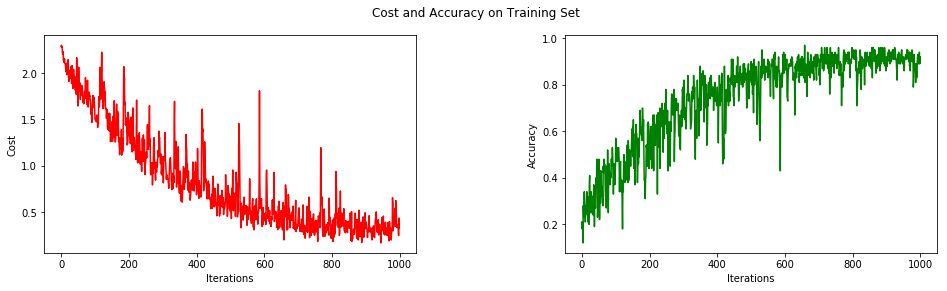

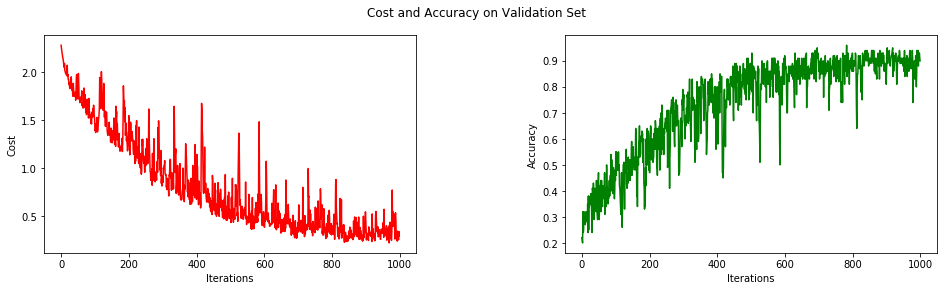

In [79]:
fig_tr, ax_tr = plt.subplots(1, 2, figsize=(16, 4))
fig_tr.suptitle(
    "Cost and Accuracy on Training Set")
ax_tr[0].plot(cost_training_arr, '-r')
ax_tr[0].set_xlabel('Iterations')
ax_tr[0].set_ylabel('Cost')
ax_tr[1].plot(accuracy_training_arr, '-g')
ax_tr[1].set_xlabel('Iterations')
ax_tr[1].set_ylabel('Accuracy')
fig_tr.subplots_adjust(wspace=.4)
plt.show()

fig_v, ax_v = plt.subplots(1, 2, figsize=(16, 4))
fig_v.suptitle(
    "Cost and Accuracy on Validation Set")
ax_v[0].plot(cost_valid_arr, '-r')
ax_v[0].set_xlabel('Iterations')
ax_v[0].set_ylabel('Cost')
ax_v[1].plot(accuracy_valid_arr, '-g')
ax_v[1].set_xlabel('Iterations')
ax_v[1].set_ylabel('Accuracy')
fig_v.subplots_adjust(wspace=.4)

plt.show()

<p>After the training is complete, we can compute the prediction accuracy of our RNN on the entire test set. This will give us an idea of how our model will perform on unseen data.</p>

In [80]:
# Obtain testing cost and predictions
test_cost, test_pred = cost_pred(X_test, Y_test)

# Compute testing accuracy
test_accuracy = np.mean(Yt_labels == test_pred)

print('Testing accuracy: %f %%' % (test_accuracy * 100.))

Testing accuracy: 90.430000 %


### Discussions

Recurrent neural network is suitable for handwriting recognition task, because it incorperates sequential context information into the model. The result of 90.4% accuracy is decent and comparable to that of convolutional neural network implemented in previous assignments. \linebreak

The cost and accuracy reaches local optimum at around 800 iterations. Since we are using mini batches of 100 samples rather the whole batch, there are some large fluctuations due to the bias of gradients of those mini batchs, but it works fine. \linebreak

There are a few options to improve the result: 
\begin{enumerate}
\item Try different activation function in hidden layer and output layer
\item Increase the number of hidden layer neurons
\item Try different weight initialization
\item Apply regularization
\item Try different mini batch size and learning rate and allow more iterations
\item Apply dropout
\item Combine recurrent and convolutional neural networks
\end{enumerate}